In [1]:
import os
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.cuda.amp import GradScaler

# Import utils
from utils.Logger import Logger
from utils.Seed import set_seed
from utils.Splitter import stratified_split
from classes.FeatureDataset.CombinedFeatureDataset import CombinedFeatureDataset
from classes.FeatureDataset.WaveformFeatureDataset import WaveformFeatureDataset
from classes.FeatureDataset.ListDataset import ListDataset

# Import RawNet1 components
from classes.models.RawNets.RawNet1.model_RawNet1_preprocessed import RawNet
from classes.models.RawNets.RawNet1.trainer_RawNet1 import test_rawnet1, load_model_rawnet1, test_rawnet1_with_loaders

# Import RawNet2 components
from classes.models.RawNets.RawNet2.model_RawNet2_preprocessed import RawNet2
from classes.models.RawNets.RawNet2.trainer_RawNet2 import test_rawnet2, load_model_rawnet2, test_rawnet2_with_loaders

# Import RawNet3 components
from classes.models.RawNets.RawNet3.model_RawNet3_preprocessed import RawNet3
from classes.models.RawNets.RawNet3.trainer_RawNet3 import test_rawnet3, load_model_rawnet3, test_rawnet3_with_loaders

seed = 42
set_seed(42)

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = ""

device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 32
learning_rate = 0.0001
epochs = 5

main_keys = [
    "seen all samples",
    "unseen all samples (UID) w/ Google TTS",
    "unseen all samples (UnID)"
]

# Combined (GF)

In [2]:
# samples will be stored here:
combined_test_samples = {
    "spoof elevenmultilingualv2 converted samples": [],
    "spoof elevenmultilingualv2 tts samples": [],
    "spoof dupdub converted samples": [],
    "spoof dupdub tts samples": [],
    "spoof dupdub notindataset tts samples": [],
    "spoof facebookmms converted samples": [],
    "spoof facebookmms tts samples": [],
    "spoof googletts converted samples": [],
    "spoof googletts tts samples": [],
    "spoof vits converted samples": [],
    "spoof vits tts samples": [],
    "bonafide commonvoice samples": [],
    "bonafide prosa samples": [],
    
    "spoof all samples": [],
    "bonafide all samples": [],
    
    "seen all samples": [],
    "unseen all samples (UID)": [],
    "unseen all samples (UID) w/ Google TTS": [],
    "unseen all samples (UnID)": [],
}

# unseen spoof datasets
combined_spoof_elevenmultilingualv2_converted_dir = "test_preprocessed_data/combined/Spoof/Converted/ElevenMultilingualV2"
combined_spoof_elevenmultilingualv2_tts_dir = "test_preprocessed_data/combined/Spoof/TTS/ElevenMultilingualV2"
combined_spoof_dupdub_converted_dir = "test_preprocessed_data/combined/Spoof/Converted/DupDub"
combined_spoof_dupdub_tts_dir = "test_preprocessed_data/combined/Spoof/TTS/DupDub"
combined_spoof_dupdub_notindataset_tts_dir = "test_preprocessed_data/combined/Spoof/TTS/DupDub-NotInDataset"

# seen spoof datasets
combined_spoof_facebookmms_converted_dir = "preprocessed_data/combined/Spoof/Converted/FacebookMMS"
combined_spoof_facebookmms_tts_dir = "preprocessed_data/combined/Spoof/TTS/FacebookMMS"
combined_spoof_googletts_converted_dir = "preprocessed_data/combined/Spoof/Converted/GoogleTTS"
combined_spoof_googletts_tts_dir = "preprocessed_data/combined/Spoof/TTS/GoogleTTS"
combined_spoof_vits_converted_dir = "preprocessed_data/combined/Spoof/Converted/VITS"
combined_spoof_vits_tts_dir = "preprocessed_data/combined/Spoof/TTS/VITS"

# Bonafide datasets (split each, DataLoader per split, do not combine)
combined_bonafide_commonvoice_dir = "preprocessed_data/combined/Bonafide/CommonVoice"
combined_bonafide_prosa_dir = "preprocessed_data/combined/Bonafide/Prosa"

## ------------------------------------
## UNSEEN SPOOF DATASETS
## ------------------------------------

# ElevenMultilingualV2 Converted
if os.path.exists(combined_spoof_elevenmultilingualv2_converted_dir):
    combined_spoof_elevenmultilingualv2_converted_dataset = CombinedFeatureDataset(combined_spoof_elevenmultilingualv2_converted_dir, force_label=0)
    combined_spoof_elevenmultilingualv2_converted_list = ListDataset([(features, 0) for features, _ in combined_spoof_elevenmultilingualv2_converted_dataset.samples])
    combined_test_samples["spoof elevenmultilingualv2 converted samples"].extend(combined_spoof_elevenmultilingualv2_converted_list)
    combined_test_samples["spoof all samples"].extend(combined_spoof_elevenmultilingualv2_converted_list)
    combined_test_samples["unseen all samples (UID)"].extend(combined_spoof_elevenmultilingualv2_converted_list)
    combined_test_samples["unseen all samples (UID) w/ Google TTS"].extend(combined_spoof_elevenmultilingualv2_converted_list)

    print(f"Loaded {len(combined_spoof_elevenmultilingualv2_converted_list)} samples from {combined_spoof_elevenmultilingualv2_converted_dir}")
else:
    print(f"Warning: Directory not found: {combined_spoof_elevenmultilingualv2_converted_dir}")

# ElevenMultilingualV2 TTS
if os.path.exists(combined_spoof_elevenmultilingualv2_tts_dir):
    combined_spoof_elevenmultilingualv2_tts_dataset = CombinedFeatureDataset(combined_spoof_elevenmultilingualv2_tts_dir, force_label=0)
    combined_spoof_elevenmultilingualv2_tts_list = ListDataset([(features, 0) for features, _ in combined_spoof_elevenmultilingualv2_tts_dataset.samples])
    combined_test_samples["spoof elevenmultilingualv2 tts samples"].extend(combined_spoof_elevenmultilingualv2_tts_list)
    combined_test_samples["spoof all samples"].extend(combined_spoof_elevenmultilingualv2_tts_list)
    combined_test_samples["unseen all samples (UID)"].extend(combined_spoof_elevenmultilingualv2_tts_list)
    combined_test_samples["unseen all samples (UID) w/ Google TTS"].extend(combined_spoof_elevenmultilingualv2_tts_list)

    print(f"Loaded {len(combined_spoof_elevenmultilingualv2_tts_list)} samples from {combined_spoof_elevenmultilingualv2_tts_dir}")
else:
    print(f"Warning: Directory not found: {combined_spoof_elevenmultilingualv2_tts_dir}")

# DupDub Converted
if os.path.exists(combined_spoof_dupdub_converted_dir):
    combined_spoof_dupdub_converted_dataset = CombinedFeatureDataset(combined_spoof_dupdub_converted_dir, force_label=0)
    combined_spoof_dupdub_converted_list = ListDataset([(features, 0) for features, _ in combined_spoof_dupdub_converted_dataset.samples])
    combined_test_samples["spoof dupdub converted samples"].extend(combined_spoof_dupdub_converted_list)
    combined_test_samples["spoof all samples"].extend(combined_spoof_dupdub_converted_list)
    combined_test_samples["unseen all samples (UID)"].extend(combined_spoof_dupdub_converted_list)
    combined_test_samples["unseen all samples (UID) w/ Google TTS"].extend(combined_spoof_dupdub_converted_list)

    print(f"Loaded {len(combined_spoof_dupdub_converted_list)} samples from {combined_spoof_dupdub_converted_dir}")
else:
    print(f"Warning: Directory not found: {combined_spoof_dupdub_converted_dir}")

# DupDub TTS
if os.path.exists(combined_spoof_dupdub_tts_dir):
    combined_spoof_dupdub_tts_dataset = CombinedFeatureDataset(combined_spoof_dupdub_tts_dir, force_label=0)
    combined_spoof_dupdub_tts_list = ListDataset([(features, 0) for features, _ in combined_spoof_dupdub_tts_dataset.samples])
    combined_test_samples["spoof dupdub tts samples"].extend(combined_spoof_dupdub_tts_list)
    combined_test_samples["spoof all samples"].extend(combined_spoof_dupdub_tts_list)
    combined_test_samples["unseen all samples (UID)"].extend(combined_spoof_dupdub_tts_list)
    combined_test_samples["unseen all samples (UID) w/ Google TTS"].extend(combined_spoof_dupdub_tts_list)

    print(f"Loaded {len(combined_spoof_dupdub_tts_list)} samples from {combined_spoof_dupdub_tts_dir}")
else:
    print(f"Warning: Directory not found: {combined_spoof_dupdub_tts_dir}")

# DupDub NotInDataset TTS
if os.path.exists(combined_spoof_dupdub_notindataset_tts_dir):
    combined_spoof_dupdub_notindataset_tts_dataset = CombinedFeatureDataset(combined_spoof_dupdub_notindataset_tts_dir, force_label=0)
    combined_spoof_dupdub_notindataset_tts_list = ListDataset([(features, 0) for features, _ in combined_spoof_dupdub_notindataset_tts_dataset.samples])
    combined_test_samples["spoof dupdub notindataset tts samples"].extend(combined_spoof_dupdub_notindataset_tts_list)
    combined_test_samples["spoof all samples"].extend(combined_spoof_dupdub_notindataset_tts_list)
    combined_test_samples["unseen all samples (UnID)"].extend(combined_spoof_dupdub_notindataset_tts_list)
    combined_test_samples["unseen all samples (UID) w/ Google TTS"].extend(combined_spoof_dupdub_notindataset_tts_list)

    print(f"Loaded {len(combined_spoof_dupdub_notindataset_tts_list)} samples from {combined_spoof_dupdub_notindataset_tts_dir}")
else:
    print(f"Warning: Directory not found: {combined_spoof_dupdub_notindataset_tts_dir}")

# GoogleTTS TTS
if os.path.exists(combined_spoof_googletts_tts_dir):
    dataset_combined_spoof_googletts_tts = CombinedFeatureDataset(combined_spoof_googletts_tts_dir, force_label=0)
    combined_spoof_googletts_tts = ListDataset([(features, 0) for features, _ in dataset_combined_spoof_googletts_tts.samples])
    t_gtt, v_gtt, te_gtt = stratified_split(combined_spoof_googletts_tts, splits=(0.7, 0.15, 0.15), seed=seed)

    combined_spoof_googletts_tts_list = ListDataset([combined_spoof_googletts_tts[i] for i in range(len(te_gtt))])
    combined_test_samples["spoof googletts tts samples"].extend(combined_spoof_googletts_tts_list)
    combined_test_samples["spoof all samples"].extend(combined_spoof_googletts_tts_list)
    combined_test_samples["unseen all samples (UID) w/ Google TTS"].extend(combined_spoof_googletts_tts_list)

    print(f"Loaded {len(combined_spoof_googletts_tts_list)} samples from {combined_spoof_googletts_tts_dir}")
else:
    print(f"Warning: Directory not found: {combined_spoof_googletts_tts_dir}")
    
## ------------------------------------
## SEEN SPOOF DATASETS
## ------------------------------------

# FacebookMMS Converted
if os.path.exists(combined_spoof_facebookmms_converted_dir):
    dataset_combined_spoof_facebookmms_converted = CombinedFeatureDataset(combined_spoof_facebookmms_converted_dir, force_label=0)
    combined_spoof_facebookmms_converted = ListDataset([(features, 0) for features, _ in dataset_combined_spoof_facebookmms_converted.samples])
    t_fmc, v_fmc, te_fmc = stratified_split(combined_spoof_facebookmms_converted, splits=(0.7, 0.15, 0.15), seed=seed)

    combined_spoof_facebookmms_converted_list = ListDataset([combined_spoof_facebookmms_converted[i] for i in range(len(te_fmc))])
    combined_test_samples["spoof facebookmms converted samples"].extend(combined_spoof_facebookmms_converted_list)
    combined_test_samples["spoof all samples"].extend(combined_spoof_facebookmms_converted_list)
    combined_test_samples["seen all samples"].extend(combined_spoof_facebookmms_converted_list)

    print(f"Loaded {len(combined_spoof_facebookmms_converted_list)} samples from {combined_spoof_facebookmms_converted_dir}")
else:
    print(f"Warning: Directory not found: {combined_spoof_facebookmms_converted_dir}")

# FacebookMMS TTS
if os.path.exists(combined_spoof_facebookmms_tts_dir):
    dataset_combined_spoof_facebookmms_tts = CombinedFeatureDataset(combined_spoof_facebookmms_tts_dir, force_label=0)
    combined_spoof_facebookmms_tts = ListDataset([(features, 0) for features, _ in dataset_combined_spoof_facebookmms_tts.samples])
    t_fmt, v_fmt, te_fmt = stratified_split(combined_spoof_facebookmms_tts, splits=(0.7, 0.15, 0.15), seed=seed)
    
    combined_spoof_facebookmms_tts_list = ListDataset([combined_spoof_facebookmms_tts[i] for i in range(len(te_fmt))])
    combined_test_samples["spoof facebookmms tts samples"].extend(combined_spoof_facebookmms_tts_list)
    combined_test_samples["spoof all samples"].extend(combined_spoof_facebookmms_tts_list)
    combined_test_samples["seen all samples"].extend(combined_spoof_facebookmms_tts_list)

    print(f"Loaded {len(combined_spoof_facebookmms_tts_list)} samples from {combined_spoof_facebookmms_tts_dir}")
else:
    print(f"Warning: Directory not found: {combined_spoof_facebookmms_tts_dir}")

# GoogleTTS Converted
if os.path.exists(combined_spoof_googletts_converted_dir):
    dataset_combined_spoof_googletts_converted = CombinedFeatureDataset(combined_spoof_googletts_converted_dir, force_label=0)
    combined_spoof_googletts_converted = ListDataset([(features, 0) for features, _ in dataset_combined_spoof_googletts_converted.samples])
    t_gtc, v_gtc, te_gtc = stratified_split(combined_spoof_googletts_converted, splits=(0.7, 0.15, 0.15), seed=seed)

    combined_spoof_googletts_converted_list = ListDataset([combined_spoof_googletts_converted[i] for i in range(len(te_gtc))])
    combined_test_samples["spoof googletts converted samples"].extend(combined_spoof_googletts_converted_list)
    combined_test_samples["spoof all samples"].extend(combined_spoof_googletts_converted_list)
    combined_test_samples["seen all samples"].extend(combined_spoof_googletts_converted_list)

    print(f"Loaded {len(combined_spoof_googletts_converted_list)} samples from {combined_spoof_googletts_converted_dir}")
else:
    print(f"Warning: Directory not found: {combined_spoof_googletts_converted_dir}")

# VITS Converted
if os.path.exists(combined_spoof_vits_converted_dir):
    dataset_combined_spoof_vits_converted = CombinedFeatureDataset(combined_spoof_vits_converted_dir, force_label=0)
    combined_spoof_vits_converted = ListDataset([(features, 0) for features, _ in dataset_combined_spoof_vits_converted.samples])
    t_vc, v_vc, te_vc = stratified_split(combined_spoof_vits_converted, splits=(0.7, 0.15, 0.15), seed=seed)

    combined_spoof_vits_converted_list = ListDataset([combined_spoof_vits_converted[i] for i in range(len(te_vc))])
    combined_test_samples["spoof vits converted samples"].extend(combined_spoof_vits_converted_list)
    combined_test_samples["spoof all samples"].extend(combined_spoof_vits_converted_list)
    combined_test_samples["seen all samples"].extend(combined_spoof_vits_converted_list)

    print(f"Loaded {len(combined_spoof_vits_converted_list)} samples from {combined_spoof_vits_converted_dir}")
else:
    print(f"Warning: Directory not found: {combined_spoof_vits_converted_dir}")

# VITS TTS
if os.path.exists(combined_spoof_vits_tts_dir):
    dataset_combined_spoof_vits_tts = CombinedFeatureDataset(combined_spoof_vits_tts_dir, force_label=0)
    combined_spoof_vits_tts = ListDataset([(features, 0) for features, _ in dataset_combined_spoof_vits_tts.samples])
    t_vt, v_vt, te_vt = stratified_split(combined_spoof_vits_tts, splits=(0.7, 0.15, 0.15), seed=seed)

    combined_spoof_vits_tts_list = ListDataset([combined_spoof_vits_tts[i] for i in range(len(te_vt))])
    combined_test_samples["spoof vits tts samples"].extend(combined_spoof_vits_tts_list)
    combined_test_samples["spoof all samples"].extend(combined_spoof_vits_tts_list)
    combined_test_samples["seen all samples"].extend(combined_spoof_vits_tts_list)

    print(f"Loaded {len(combined_spoof_vits_tts_list)} samples from {combined_spoof_vits_tts_dir}")
else:
    print(f"Warning: Directory not found: {combined_spoof_vits_tts_dir}")

### Bonafides will be added to "unseen all samples (UID)", "unseen all samples (UnID)", and "seen all samples" so that evaluation metrics can be calculated
# Bonafide CommonVoice
if os.path.exists(combined_bonafide_commonvoice_dir):
    dataset_commonvoice = CombinedFeatureDataset(combined_bonafide_commonvoice_dir, force_label=1)
    combined_bonafide_commonvoice = ListDataset([(features, 1) for features, _ in dataset_commonvoice.samples])
    t_c, v_c, te_c = stratified_split(combined_bonafide_commonvoice, splits=(0.7, 0.15, 0.15), seed=seed)

    combined_bonafide_commonvoice_list = ListDataset([combined_bonafide_commonvoice[i] for i in range(len(te_c))])
    combined_test_samples["bonafide commonvoice samples"].extend(combined_bonafide_commonvoice_list)
    combined_test_samples["bonafide all samples"].extend(combined_bonafide_commonvoice_list)
    combined_test_samples["seen all samples"].extend(combined_bonafide_commonvoice_list)
    combined_test_samples["unseen all samples (UID)"].extend(combined_bonafide_commonvoice_list)
    combined_test_samples["unseen all samples (UID) w/ Google TTS"].extend(combined_bonafide_commonvoice_list)
    combined_test_samples["unseen all samples (UnID)"].extend(combined_bonafide_commonvoice_list)

    print(f"Loaded {len(combined_bonafide_commonvoice_list)} samples from {combined_bonafide_commonvoice_dir}")
else:
    print(f"Warning: Directory not found: {combined_bonafide_commonvoice_dir}")

# Bonafide Prosa
if os.path.exists(combined_bonafide_prosa_dir):
    dataset_prosa = CombinedFeatureDataset(combined_bonafide_prosa_dir, force_label=1)
    combined_bonafide_prosa = ListDataset([(features, 1) for features, _ in dataset_prosa.samples])
    t_p, v_p, te_p = stratified_split(combined_bonafide_prosa, splits=(0.7, 0.15, 0.15), seed=seed)

    combined_bonafide_prosa_list = ListDataset([combined_bonafide_prosa[i] for i in range(len(te_p))])
    combined_test_samples["bonafide prosa samples"].extend(combined_bonafide_prosa_list)
    combined_test_samples["bonafide all samples"].extend(combined_bonafide_prosa_list)
    combined_test_samples["seen all samples"].extend(combined_bonafide_prosa_list)
    combined_test_samples["unseen all samples (UID)"].extend(combined_bonafide_prosa_list)
    combined_test_samples["unseen all samples (UID) w/ Google TTS"].extend(combined_bonafide_prosa_list)
    combined_test_samples["unseen all samples (UnID)"].extend(combined_bonafide_prosa_list)

    print(f"Loaded {len(combined_bonafide_prosa_list)} samples from {combined_bonafide_prosa_dir}")
else:
    print(f"Warning: Directory not found: {combined_bonafide_prosa_dir}")

print("-----------------------------------------------")
print(f"Total test spoof samples: {len(combined_test_samples['spoof all samples'])}")
print(f"Total test bonafide samples: {len(combined_test_samples['bonafide all samples'])}")
print("-----------------------------------------------")
print(f"Total seen test spoof samples: {len(combined_test_samples['seen all samples'])}")
print(f"Total unseen UID samples: {len(combined_test_samples['unseen all samples (UID)'])}")
print(f"Total unseen UnID samples: {len(combined_test_samples['unseen all samples (UnID)'])}")
print("-----------------------------------------------")

combined_test_samples_dataloaders = {
    key: DataLoader(value, batch_size=batch_size, shuffle=False, num_workers=4)
    for key, value in combined_test_samples.items()
}

Skipped 0 files due to NaNs/Infs.
Loaded 746 samples from test_preprocessed_data/combined/Spoof/Converted/ElevenMultilingualV2
Skipped 0 files due to NaNs/Infs.
Loaded 751 samples from test_preprocessed_data/combined/Spoof/TTS/ElevenMultilingualV2
Skipped 0 files due to NaNs/Infs.
Loaded 53 samples from test_preprocessed_data/combined/Spoof/Converted/DupDub
Skipped 0 files due to NaNs/Infs.
Loaded 101 samples from test_preprocessed_data/combined/Spoof/TTS/DupDub
Skipped 0 files due to NaNs/Infs.
Loaded 111 samples from test_preprocessed_data/combined/Spoof/TTS/DupDub-NotInDataset
Skipped 0 files due to NaNs/Infs.
Loaded 2461 samples from preprocessed_data/combined/Spoof/TTS/GoogleTTS
Skipped 0 files due to NaNs/Infs.
Loaded 1249 samples from preprocessed_data/combined/Spoof/Converted/FacebookMMS
Skipped 0 files due to NaNs/Infs.
Loaded 2517 samples from preprocessed_data/combined/Spoof/TTS/FacebookMMS
Skipped 0 files due to NaNs/Infs.
Loaded 1225 samples from preprocessed_data/combined

## RawNet1

Loaded model from pretrained_weights/combined/RawNet1/rawnet1_combined-ep_30-bs_32-lr_0.0001.pth (epoch 29)
Testing spoof elevenmultilingualv2 converted samples
Testing spoof elevenmultilingualv2 tts samples
Testing spoof dupdub converted samples
Testing spoof dupdub tts samples
Testing spoof dupdub notindataset tts samples
Testing spoof facebookmms converted samples
Testing spoof facebookmms tts samples
Testing spoof googletts converted samples
Testing spoof googletts tts samples
Testing spoof vits converted samples
Testing spoof vits tts samples
Testing bonafide commonvoice samples
Testing bonafide prosa samples
Testing spoof all samples
Testing bonafide all samples
Testing seen all samples
              --> Val Acc: 100.00%
              --> Balanced Acc: 1.0000 | Precision: 1.0000
              --> Recall: 1.0000 | F1: 1.0000 | F2: 1.0000
              --> EER: 0.0000 | actDCF: 1.0000 | minDCF: 0.0000
              --> CLLR: 0.0000


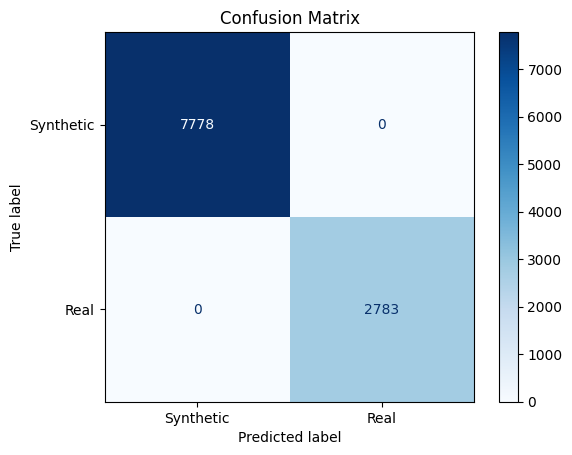

Testing unseen all samples (UID)
              --> Val Acc: 80.81%
              --> Balanced Acc: 0.7423 | Precision: 0.7658
              --> Recall: 1.0000 | F1: 0.8674 | F2: 0.9424
              --> EER: 0.1120 | actDCF: 1.0000 | minDCF: 0.2137
              --> CLLR: 4.8216


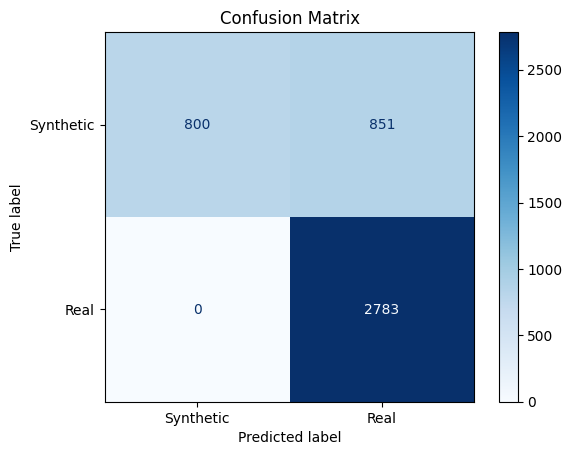

Testing unseen all samples (UID) w/ Google TTS
              --> Val Acc: 63.57%
              --> Balanced Acc: 0.6978 | Precision: 0.5216
              --> Recall: 1.0000 | F1: 0.6856 | F2: 0.8450
              --> EER: 0.0734 | actDCF: 1.0000 | minDCF: 0.1468
              --> CLLR: 3.9699


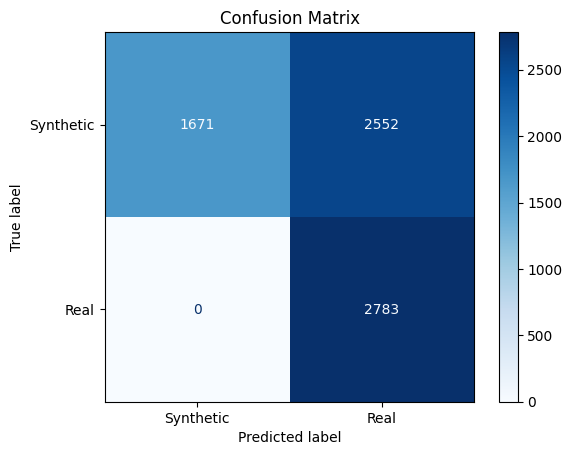

Testing unseen all samples (UnID)
              --> Val Acc: 96.20%
              --> Balanced Acc: 0.5045 | Precision: 0.9620
              --> Recall: 1.0000 | F1: 0.9806 | F2: 0.9922
              --> EER: 0.0493 | actDCF: 1.0000 | minDCF: 0.0783
              --> CLLR: 8.3377


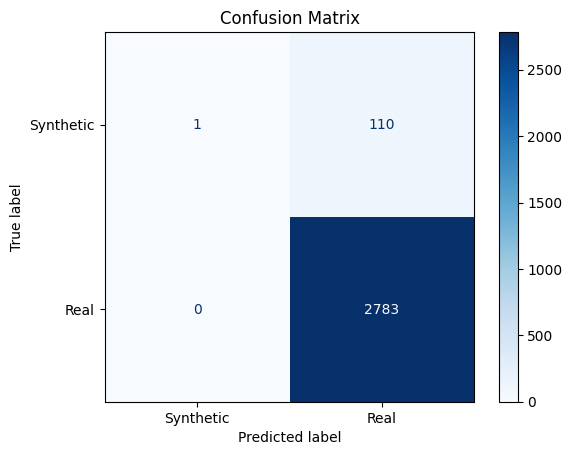

In [3]:
combined_model_config = {
    'in_channels': 1,
    'first_conv': 3,
    'filts': [128, [128, 128], [128, 256], [256, 256]],
    'blocks': [2, 4],
    'gru_node': 1024,
    'nb_gru_layer': 1,
    'nb_fc_node': 1024,
    'nb_classes': 2
}

# --- Set up model, optimizer, and scaler ---
model = RawNet(combined_model_config, device).to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
scaler = GradScaler()

# --- Load the model ---
start_epoch = load_model_rawnet1(
    model, optimizer, scaler,
    path=r"pretrained_weights/combined/RawNet1/rawnet1_combined-ep_30-bs_32-lr_0.0001.pth"
)

for key, test_sample in combined_test_samples_dataloaders.items():
    print(f"Testing {key}")
    if key in main_keys:
        predictions, targets, metrics = test_rawnet1(model, test_sample, device=device)
    # else:
    #     predictions = test_rawnet1_with_loaders(model, test_sample, device=device)
    #     print(predictions)
    torch.cuda.empty_cache()

## RawNet2

Loaded model from pretrained_weights/combined/RawNet2/rawnet2_combined-ep_30-bs_32-lr_0.0001.pth (epoch 29)
Testing spoof elevenmultilingualv2 converted samples
Testing spoof elevenmultilingualv2 tts samples
Testing spoof dupdub converted samples
Testing spoof dupdub tts samples
Testing spoof dupdub notindataset tts samples
Testing spoof facebookmms converted samples
Testing spoof facebookmms tts samples
Testing spoof googletts converted samples
Testing spoof googletts tts samples
Testing spoof vits converted samples
Testing spoof vits tts samples
Testing bonafide commonvoice samples
Testing bonafide prosa samples
Testing spoof all samples
Testing bonafide all samples
Testing seen all samples
              --> Val Acc: 100.00%
              --> Balanced Acc: 1.0000 | Precision: 1.0000
              --> Recall: 1.0000 | F1: 1.0000 | F2: 1.0000
              --> EER: 0.0000 | actDCF: 1.0000 | minDCF: 0.0000
              --> CLLR: 0.0000


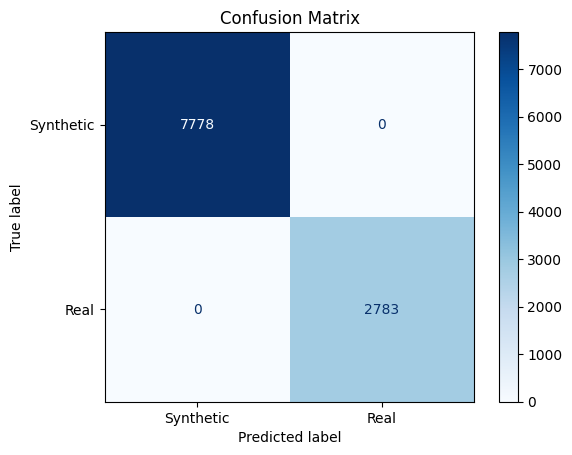

Testing unseen all samples (UID)
              --> Val Acc: 97.11%
              --> Balanced Acc: 0.9612 | Precision: 0.9560
              --> Recall: 1.0000 | F1: 0.9775 | F2: 0.9909
              --> EER: 0.0411 | actDCF: 1.0000 | minDCF: 0.0597
              --> CLLR: 0.4969


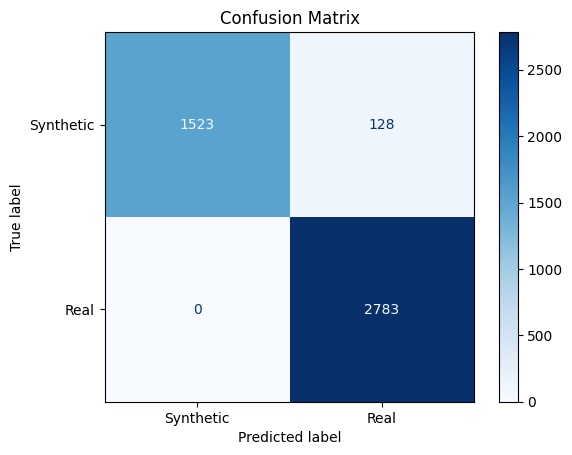

Testing unseen all samples (UID) w/ Google TTS
              --> Val Acc: 94.95%
              --> Balanced Acc: 0.9581 | Precision: 0.8872
              --> Recall: 1.0000 | F1: 0.9402 | F2: 0.9752
              --> EER: 0.0264 | actDCF: 1.0000 | minDCF: 0.0396
              --> CLLR: 0.4065


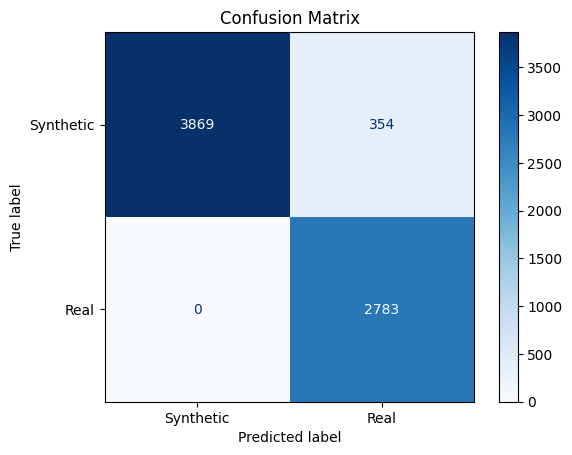

Testing unseen all samples (UnID)
              --> Val Acc: 96.23%
              --> Balanced Acc: 0.5090 | Precision: 0.9623
              --> Recall: 1.0000 | F1: 0.9808 | F2: 0.9922
              --> EER: 0.1080 | actDCF: 1.0000 | minDCF: 0.2001
              --> CLLR: 5.7001


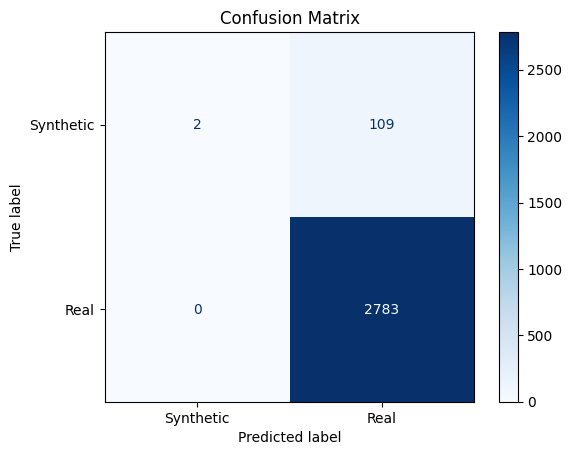

In [4]:
combined_model_config2 = {
    'in_channels': 1,
    'first_conv': 3,
    'filts': [128, [128, 128], [128, 256], [256, 256]],
    'blocks': [2, 4],
    'gru_node': 1024,
    'nb_gru_layer': 1,
    'nb_fc_node': 1024,
    'nb_classes': 2,
    'nb_samp': 16000 * 4 + 24
}

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Set up model, optimizer, and scaler ---
model = RawNet2(combined_model_config2).to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
scaler = GradScaler()

# --- Load the model ---
start_epoch = load_model_rawnet2(
    model, optimizer, scaler,
    path=r"pretrained_weights/combined/RawNet2/rawnet2_combined-ep_30-bs_32-lr_0.0001.pth"
)

for key, test_sample in combined_test_samples_dataloaders.items():
    print(f"Testing {key}")
    if key in main_keys:
        predictions, targets, metrics = test_rawnet2(model, test_sample, device=device)
    # else:
    #     predictions = test_rawnet2_with_loaders(model, test_sample, device=device)
    #     print(predictions)
    torch.cuda.empty_cache()

## RawNet3

Loaded model from pretrained_weights/combined/RawNet3/rawnet3_combined-ep_30-bs_32-lr_0.0001.pth (epoch 29)
Testing spoof elevenmultilingualv2 converted samples
Testing spoof elevenmultilingualv2 tts samples
Testing spoof dupdub converted samples
Testing spoof dupdub tts samples
Testing spoof dupdub notindataset tts samples
Testing spoof facebookmms converted samples
Testing spoof facebookmms tts samples
Testing spoof googletts converted samples
Testing spoof googletts tts samples
Testing spoof vits converted samples
Testing spoof vits tts samples
Testing bonafide commonvoice samples
Testing bonafide prosa samples
Testing spoof all samples
Testing bonafide all samples
Testing seen all samples
              --> Val Acc: 100.00%
              --> Balanced Acc: 1.0000 | Precision: 1.0000
              --> Recall: 1.0000 | F1: 1.0000 | F2: 1.0000
              --> EER: 0.0000 | actDCF: 1.0000 | minDCF: 0.0000
              --> CLLR: 0.0007


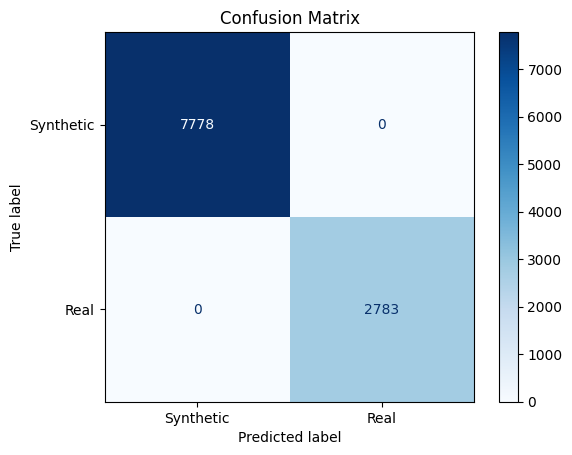

Testing unseen all samples (UID)
Testing unseen all samples (UID) w/ Google TTS
              --> Val Acc: 73.78%
              --> Balanced Acc: 0.7825 | Precision: 0.6024
              --> Recall: 1.0000 | F1: 0.7519 | F2: 0.8834
              --> EER: 0.0166 | actDCF: 1.0000 | minDCF: 0.0286
              --> CLLR: 1.3798


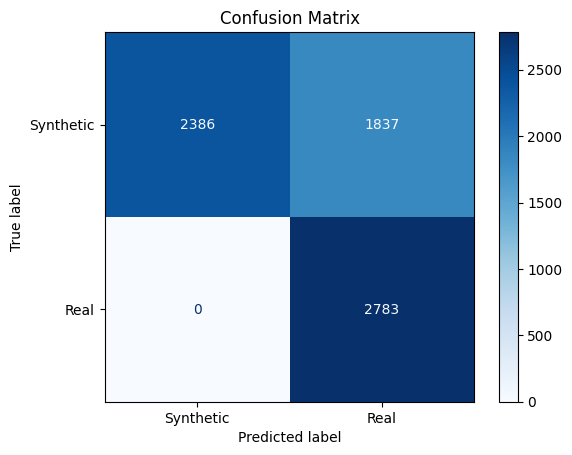

Testing unseen all samples (UnID)
              --> Val Acc: 96.48%
              --> Balanced Acc: 0.5405 | Precision: 0.9646
              --> Recall: 1.0000 | F1: 0.9820 | F2: 0.9927
              --> EER: 0.2164 | actDCF: 1.0000 | minDCF: 0.3765
              --> CLLR: 4.3093


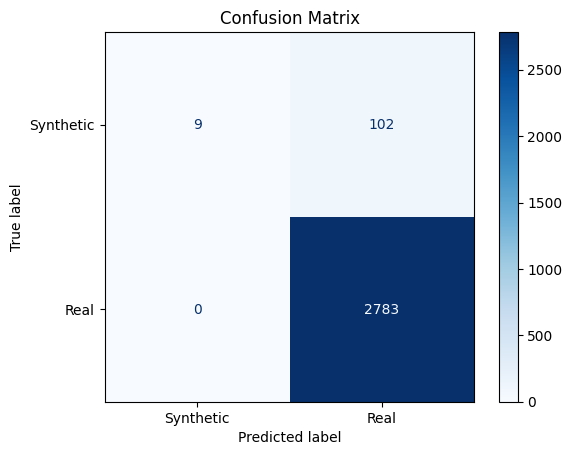

In [3]:
combined_model_config3 = {
    "nOut": 2,
    "sinc_stride": 10,
    "encoder_type": "ECA",
    "log_sinc": True,
    "norm_sinc": "mean_std",
    "out_bn": True
}

# --- Set up model, optimizer, and scaler ---
model = RawNet3(**combined_model_config3).to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
scaler = GradScaler()

# --- Load the model ---
start_epoch = load_model_rawnet3(
    model, optimizer, scaler,
    path=r"pretrained_weights/combined/RawNet3/rawnet3_combined-ep_30-bs_32-lr_0.0001.pth"
)

for key, test_sample in combined_test_samples_dataloaders.items():
    print(f"Testing {key}")
    if key in main_keys:
        predictions, targets, metrics = test_rawnet3(model, test_sample, device=device)
    # else:
    #     predictions = test_rawnet3_with_loaders(model, test_sample, device=device)
    #     print(predictions)
    torch.cuda.empty_cache()

# Combined (GA)

## RawNet1

Loaded model from pretrained_weights/diff_pipeline/RawNet1/rawnet1_diff_pipeline-ep_30-bs_32-lr_0.0001.pth (epoch 29)
Testing spoof elevenmultilingualv2 converted samples
Testing spoof elevenmultilingualv2 tts samples
Testing spoof dupdub converted samples
Testing spoof dupdub tts samples
Testing spoof dupdub notindataset tts samples
Testing spoof facebookmms converted samples
Testing spoof facebookmms tts samples
Testing spoof googletts converted samples
Testing spoof googletts tts samples
Testing spoof vits converted samples
Testing spoof vits tts samples
Testing bonafide commonvoice samples
Testing bonafide prosa samples
Testing spoof all samples
Testing bonafide all samples
Testing seen all samples
              --> Val Acc: 100.00%
              --> Balanced Acc: 1.0000 | Precision: 1.0000
              --> Recall: 1.0000 | F1: 1.0000 | F2: 1.0000
              --> EER: 0.0000 | actDCF: 1.0000 | minDCF: 0.0000
              --> CLLR: 0.0000


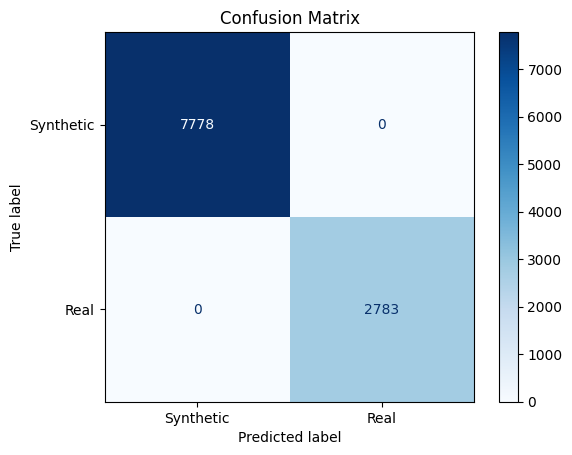

Testing unseen all samples (UID)
              --> Val Acc: 80.90%
              --> Balanced Acc: 0.7435 | Precision: 0.7667
              --> Recall: 1.0000 | F1: 0.8679 | F2: 0.9426
              --> EER: 0.0621 | actDCF: 1.0000 | minDCF: 0.1220
              --> CLLR: 3.4065


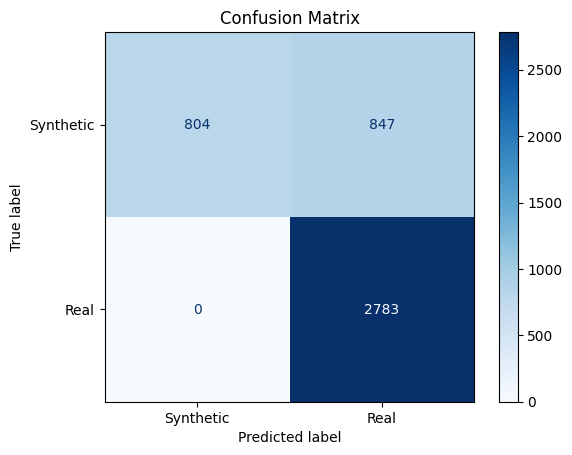

Testing unseen all samples (UID) w/ Google TTS
              --> Val Acc: 82.34%
              --> Balanced Acc: 0.8535 | Precision: 0.6923
              --> Recall: 1.0000 | F1: 0.8182 | F2: 0.9184
              --> EER: 0.0376 | actDCF: 1.0000 | minDCF: 0.0730
              --> CLLR: 1.6185


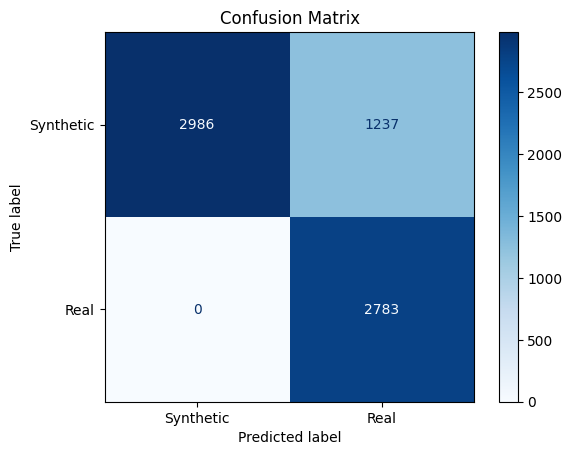

Testing unseen all samples (UnID)
              --> Val Acc: 96.65%
              --> Balanced Acc: 0.5631 | Precision: 0.9663
              --> Recall: 1.0000 | F1: 0.9829 | F2: 0.9931
              --> EER: 0.0729 | actDCF: 1.0000 | minDCF: 0.1319
              --> CLLR: 4.7695


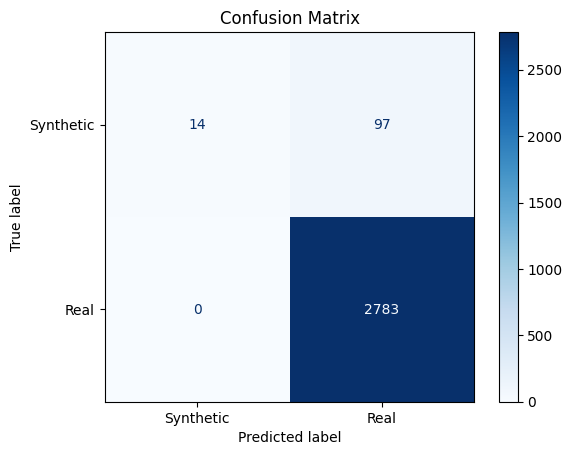

In [6]:
# Import RawNet1 components
from classes.models.RawNets.RawNet1.model_RawNet1_preprocessed_diff_pipeline import RawNet as RawNetv2

combined_model_config = {
    'in_channels': 1,
    'first_conv': 3,
    'filts': [128, [128, 128], [128, 256], [256, 256]],
    'blocks': [2, 4],
    'gru_node': 1024,
    'nb_gru_layer': 1,
    'nb_fc_node': 1024,
    'nb_classes': 2
}

# --- Set up model, optimizer, and scaler ---
model = RawNetv2(combined_model_config, device).to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
scaler = GradScaler()

# --- Load the model ---
start_epoch = load_model_rawnet1(
    model, optimizer, scaler,
    path=r"pretrained_weights/diff_pipeline/RawNet1/rawnet1_diff_pipeline-ep_30-bs_32-lr_0.0001.pth"
)

for key, test_sample in combined_test_samples_dataloaders.items():
    print(f"Testing {key}")
    if key in main_keys:
        predictions, targets, metrics = test_rawnet1(model, test_sample, device=device)
    # else:
    #     predictions = test_rawnet1_with_loaders(model, test_sample, device=device)
    #     print(predictions)
    torch.cuda.empty_cache()

## RawNet2

Loaded model from pretrained_weights/diff_pipeline/RawNet2/rawnet2_diff_pipeline-ep_30-bs_32-lr_0.0001.pth (epoch 29)
Testing spoof elevenmultilingualv2 converted samples
Testing spoof elevenmultilingualv2 tts samples
Testing spoof dupdub converted samples
Testing spoof dupdub tts samples
Testing spoof dupdub notindataset tts samples
Testing spoof facebookmms converted samples
Testing spoof facebookmms tts samples
Testing spoof googletts converted samples
Testing spoof googletts tts samples
Testing spoof vits converted samples
Testing spoof vits tts samples
Testing bonafide commonvoice samples
Testing bonafide prosa samples
Testing spoof all samples
Testing bonafide all samples
Testing seen all samples
              --> Val Acc: 100.00%
              --> Balanced Acc: 1.0000 | Precision: 1.0000
              --> Recall: 1.0000 | F1: 1.0000 | F2: 1.0000
              --> EER: 0.0000 | actDCF: 1.0000 | minDCF: 0.0000
              --> CLLR: 0.0000


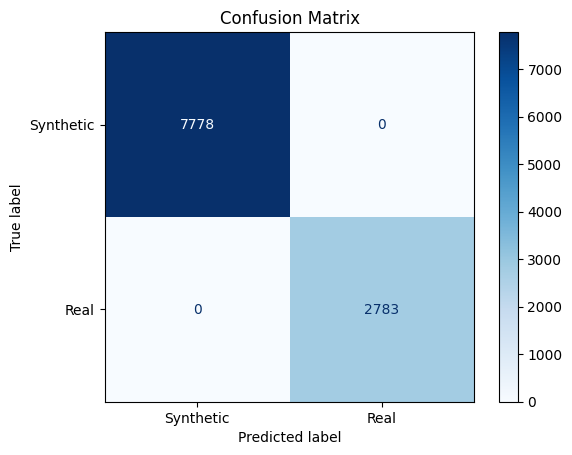

Testing unseen all samples (UID)
              --> Val Acc: 96.55%
              --> Balanced Acc: 0.9537 | Precision: 0.9479
              --> Recall: 1.0000 | F1: 0.9732 | F2: 0.9891
              --> EER: 0.0393 | actDCF: 1.0000 | minDCF: 0.0562
              --> CLLR: 0.6681


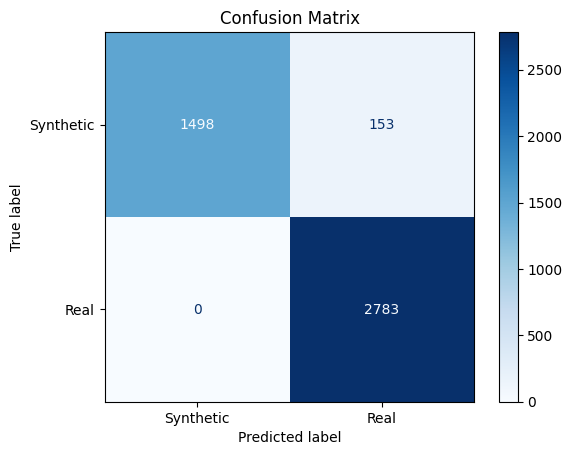

Testing unseen all samples (UID) w/ Google TTS
              --> Val Acc: 93.93%
              --> Balanced Acc: 0.9497 | Precision: 0.8675
              --> Recall: 1.0000 | F1: 0.9291 | F2: 0.9704
              --> EER: 0.0269 | actDCF: 1.0000 | minDCF: 0.0359
              --> CLLR: 0.5711


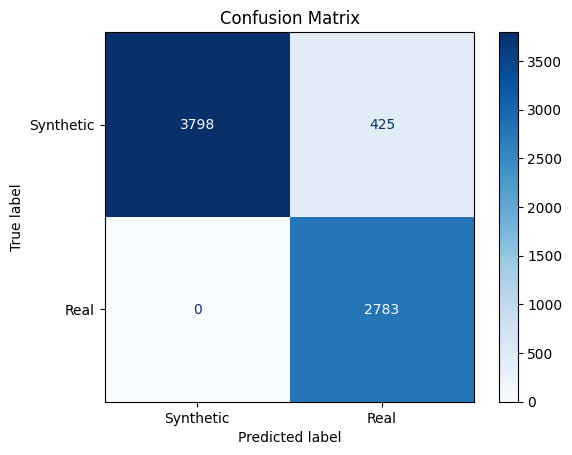

Testing unseen all samples (UnID)
              --> Val Acc: 96.54%
              --> Balanced Acc: 0.5495 | Precision: 0.9653
              --> Recall: 1.0000 | F1: 0.9824 | F2: 0.9929
              --> EER: 0.1643 | actDCF: 1.0000 | minDCF: 0.3007
              --> CLLR: 6.7793


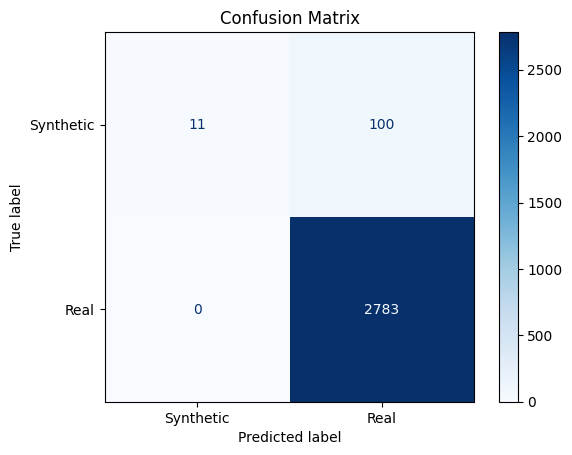

In [7]:
# Import RawNet2 components
from classes.models.RawNets.RawNet2.model_RawNet2_preprocessed_diff_pipeline import RawNet2 as RawNet2v2

combined_model_config2 = {
    'in_channels': 1,
    'first_conv': 3,
    'filts': [128, [128, 128], [128, 256], [256, 256]],
    'blocks': [2, 4],
    'gru_node': 1024,
    'nb_gru_layer': 1,
    'nb_fc_node': 1024,
    'nb_classes': 2,
    'nb_samp': 16000 * 4
}

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Set up model, optimizer, and scaler ---
model = RawNet2v2(combined_model_config2).to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
scaler = GradScaler()

# --- Load the model ---
start_epoch = load_model_rawnet2(
    model, optimizer, scaler,
    path=r"pretrained_weights/diff_pipeline/RawNet2/rawnet2_diff_pipeline-ep_30-bs_32-lr_0.0001.pth"
)

for key, test_sample in combined_test_samples_dataloaders.items():
    print(f"Testing {key}")
    if key in main_keys:
        predictions, targets, metrics = test_rawnet2(model, test_sample, device=device)
    # else:
    #     predictions = test_rawnet2_with_loaders(model, test_sample, device=device)
    #     print(predictions)
    torch.cuda.empty_cache()

## RawNet3

Loaded model from pretrained_weights/diff_pipeline/RawNet3/rawnet3_diff_pipeline-ep_30-bs_32-lr_0.0001.pth (epoch 29)
Testing spoof elevenmultilingualv2 converted samples
Testing spoof elevenmultilingualv2 tts samples
Testing spoof dupdub converted samples
Testing spoof dupdub tts samples
Testing spoof dupdub notindataset tts samples
Testing spoof facebookmms converted samples
Testing spoof facebookmms tts samples
Testing spoof googletts converted samples
Testing spoof googletts tts samples
Testing spoof vits converted samples
Testing spoof vits tts samples
Testing bonafide commonvoice samples
Testing bonafide prosa samples
Testing spoof all samples
Testing bonafide all samples
Testing seen all samples
              --> Val Acc: 100.00%
              --> Balanced Acc: 1.0000 | Precision: 1.0000
              --> Recall: 1.0000 | F1: 1.0000 | F2: 1.0000
              --> EER: 0.0000 | actDCF: 1.0000 | minDCF: 0.0000
              --> CLLR: 0.0009


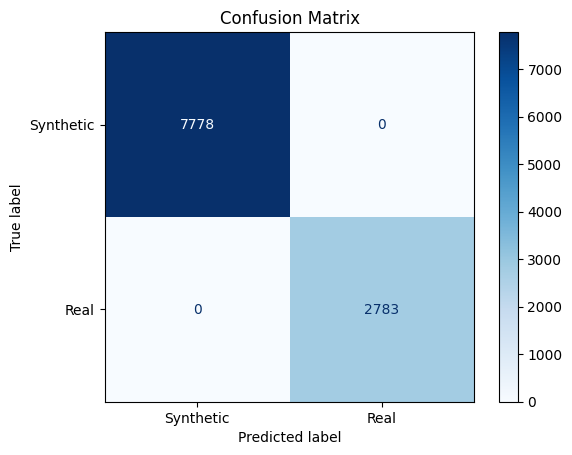

Testing unseen all samples (UID)
Testing unseen all samples (UID) w/ Google TTS
              --> Val Acc: 85.63%
              --> Balanced Acc: 0.8808 | Precision: 0.7343
              --> Recall: 1.0000 | F1: 0.8468 | F2: 0.9325
              --> EER: 0.0217 | actDCF: 1.0000 | minDCF: 0.0413
              --> CLLR: 0.7718


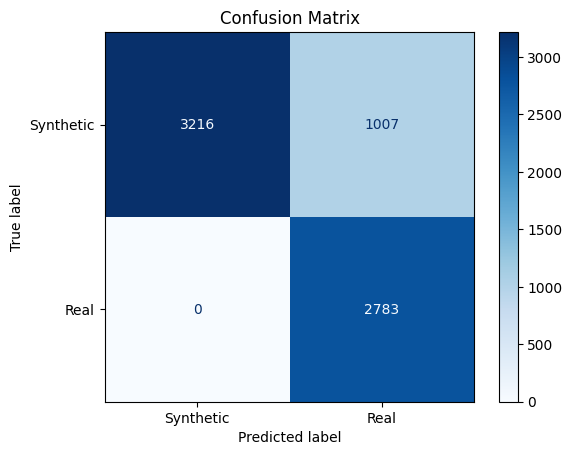

Testing unseen all samples (UnID)
              --> Val Acc: 96.54%
              --> Balanced Acc: 0.5495 | Precision: 0.9653
              --> Recall: 1.0000 | F1: 0.9824 | F2: 0.9929
              --> EER: 0.2053 | actDCF: 1.0000 | minDCF: 0.3242
              --> CLLR: 4.5550


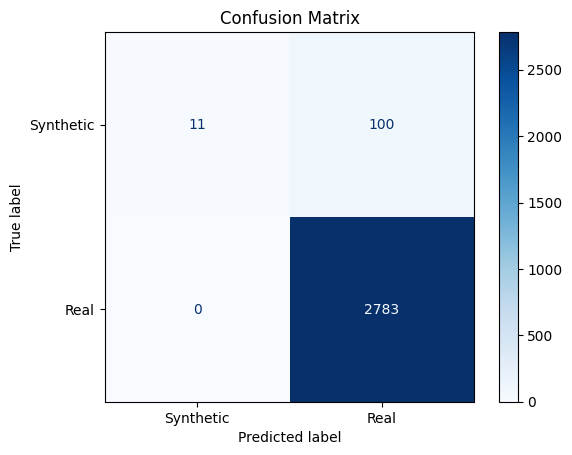

In [4]:
# Import RawNet2 components
from classes.models.RawNets.RawNet3.model_RawNet3_preprocessed_diff_pipeline import RawNet3 as RawNet3v2

combined_model_config3 = {
    "nOut": 2,
    "sinc_stride": 10,
    "encoder_type": "ECA",
    "log_sinc": True,
    "norm_sinc": "mean_std",
    "out_bn": True
}

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Set up model, optimizer, and scaler ---
model = RawNet3v2(**combined_model_config3).to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
scaler = GradScaler()

# --- Load the model ---
start_epoch = load_model_rawnet3(
    model, optimizer, scaler,
    path=r"pretrained_weights/diff_pipeline/RawNet3/rawnet3_diff_pipeline-ep_30-bs_32-lr_0.0001.pth"
)

for key, test_sample in combined_test_samples_dataloaders.items():
    print(f"Testing {key}")
    if key in main_keys:
        predictions, targets, metrics = test_rawnet3(model, test_sample, device=device)
    # else:
    #     predictions = test_rawnet3_with_loaders(model, test_sample, device=device)
    #     print(predictions)
    torch.cuda.empty_cache()

# Waveform

In [2]:
# samples will be stored here:
waveform_test_samples = {
    "spoof elevenmultilingualv2 converted samples": [],
    "spoof elevenmultilingualv2 tts samples": [],
    "spoof dupdub converted samples": [],
    "spoof dupdub tts samples": [],
    "spoof dupdub notindataset tts samples": [],
    "spoof facebookmms converted samples": [],
    "spoof facebookmms tts samples": [],
    "spoof googletts converted samples": [],
    "spoof googletts tts samples": [],
    "spoof vits converted samples": [],
    "spoof vits tts samples": [],
    "bonafide commonvoice samples": [],
    "bonafide prosa samples": [],
    
    "spoof all samples": [],
    "bonafide all samples": [],
    
    "seen all samples": [],
    "unseen all samples (UID)": [],
    "unseen all samples (UID) w/ Google TTS": [],
    "unseen all samples (UnID)": [],
}

# unseen spoof datasets
waveform_spoof_elevenmultilingualv2_converted_dir = "test_preprocessed_data/waveform/Spoof/Converted/ElevenMultilingualV2"
waveform_spoof_elevenmultilingualv2_tts_dir = "test_preprocessed_data/waveform/Spoof/TTS/ElevenMultilingualV2"
waveform_spoof_dupdub_converted_dir = "test_preprocessed_data/waveform/Spoof/Converted/DupDub"
waveform_spoof_dupdub_tts_dir = "test_preprocessed_data/waveform/Spoof/TTS/DupDub"
waveform_spoof_dupdub_notindataset_tts_dir = "test_preprocessed_data/waveform/Spoof/TTS/DupDub-NotInDataset"

# seen spoof datasets
waveform_spoof_facebookmms_converted_dir = "preprocessed_data/waveform/Spoof/Converted/FacebookMMS"
waveform_spoof_facebookmms_tts_dir = "preprocessed_data/waveform/Spoof/TTS/FacebookMMS"
waveform_spoof_googletts_converted_dir = "preprocessed_data/waveform/Spoof/Converted/GoogleTTS"
waveform_spoof_googletts_tts_dir = "preprocessed_data/waveform/Spoof/TTS/GoogleTTS"
waveform_spoof_vits_converted_dir = "preprocessed_data/waveform/Spoof/Converted/VITS"
waveform_spoof_vits_tts_dir = "preprocessed_data/waveform/Spoof/TTS/VITS"

# Bonafide datasets (split each, DataLoader per split, do not combine)
waveform_bonafide_commonvoice_dir = "preprocessed_data/waveform/Bonafide/CommonVoice"
waveform_bonafide_prosa_dir = "preprocessed_data/waveform/Bonafide/Prosa"

## ------------------------------------
## UNSEEN SPOOF DATASETS
## ------------------------------------

# ElevenMultilingualV2 Converted
if os.path.exists(waveform_spoof_elevenmultilingualv2_converted_dir):
    waveform_spoof_elevenmultilingualv2_converted_dataset = WaveformFeatureDataset(waveform_spoof_elevenmultilingualv2_converted_dir, force_label=0)
    waveform_spoof_elevenmultilingualv2_converted_list = ListDataset([(features, 0) for features, _ in waveform_spoof_elevenmultilingualv2_converted_dataset.samples])
    waveform_test_samples["spoof elevenmultilingualv2 converted samples"].extend(waveform_spoof_elevenmultilingualv2_converted_list)
    waveform_test_samples["spoof all samples"].extend(waveform_spoof_elevenmultilingualv2_converted_list)
    waveform_test_samples["unseen all samples (UID)"].extend(waveform_spoof_elevenmultilingualv2_converted_list)
    waveform_test_samples["unseen all samples (UID) w/ Google TTS"].extend(waveform_spoof_elevenmultilingualv2_converted_list)

    print(f"Loaded {len(waveform_spoof_elevenmultilingualv2_converted_list)} samples from {waveform_spoof_elevenmultilingualv2_converted_dir}")
else:
    print(f"Warning: Directory not found: {waveform_spoof_elevenmultilingualv2_converted_dir}")

# ElevenMultilingualV2 TTS
if os.path.exists(waveform_spoof_elevenmultilingualv2_tts_dir):
    waveform_spoof_elevenmultilingualv2_tts_dataset = WaveformFeatureDataset(waveform_spoof_elevenmultilingualv2_tts_dir, force_label=0)
    waveform_spoof_elevenmultilingualv2_tts_list = ListDataset([(features, 0) for features, _ in waveform_spoof_elevenmultilingualv2_tts_dataset.samples])
    waveform_test_samples["spoof elevenmultilingualv2 tts samples"].extend(waveform_spoof_elevenmultilingualv2_tts_list)
    waveform_test_samples["spoof all samples"].extend(waveform_spoof_elevenmultilingualv2_tts_list)
    waveform_test_samples["unseen all samples (UID)"].extend(waveform_spoof_elevenmultilingualv2_tts_list)
    waveform_test_samples["unseen all samples (UID) w/ Google TTS"].extend(waveform_spoof_elevenmultilingualv2_tts_list)

    print(f"Loaded {len(waveform_spoof_elevenmultilingualv2_tts_list)} samples from {waveform_spoof_elevenmultilingualv2_tts_dir}")
else:
    print(f"Warning: Directory not found: {waveform_spoof_elevenmultilingualv2_tts_dir}")

# DupDub Converted
if os.path.exists(waveform_spoof_dupdub_converted_dir):
    waveform_spoof_dupdub_converted_dataset = WaveformFeatureDataset(waveform_spoof_dupdub_converted_dir, force_label=0)
    waveform_spoof_dupdub_converted_list = ListDataset([(features, 0) for features, _ in waveform_spoof_dupdub_converted_dataset.samples])
    waveform_test_samples["spoof dupdub converted samples"].extend(waveform_spoof_dupdub_converted_list)
    waveform_test_samples["spoof all samples"].extend(waveform_spoof_dupdub_converted_list)
    waveform_test_samples["unseen all samples (UID)"].extend(waveform_spoof_dupdub_converted_list)
    waveform_test_samples["unseen all samples (UID) w/ Google TTS"].extend(waveform_spoof_dupdub_converted_list)

    print(f"Loaded {len(waveform_spoof_dupdub_converted_list)} samples from {waveform_spoof_dupdub_converted_dir}")
else:
    print(f"Warning: Directory not found: {waveform_spoof_dupdub_converted_dir}")

# DupDub TTS
if os.path.exists(waveform_spoof_dupdub_tts_dir):
    waveform_spoof_dupdub_tts_dataset = WaveformFeatureDataset(waveform_spoof_dupdub_tts_dir, force_label=0)
    waveform_spoof_dupdub_tts_list = ListDataset([(features, 0) for features, _ in waveform_spoof_dupdub_tts_dataset.samples])
    waveform_test_samples["spoof dupdub tts samples"].extend(waveform_spoof_dupdub_tts_list)
    waveform_test_samples["spoof all samples"].extend(waveform_spoof_dupdub_tts_list)
    waveform_test_samples["unseen all samples (UID)"].extend(waveform_spoof_dupdub_tts_list)
    waveform_test_samples["unseen all samples (UID) w/ Google TTS"].extend(waveform_spoof_dupdub_tts_list)

    print(f"Loaded {len(waveform_spoof_dupdub_tts_list)} samples from {waveform_spoof_dupdub_tts_dir}")
else:
    print(f"Warning: Directory not found: {waveform_spoof_dupdub_tts_dir}")

# DupDub NotInDataset TTS
if os.path.exists(waveform_spoof_dupdub_notindataset_tts_dir):
    waveform_spoof_dupdub_notindataset_tts_dataset = WaveformFeatureDataset(waveform_spoof_dupdub_notindataset_tts_dir, force_label=0)
    waveform_spoof_dupdub_notindataset_tts_list = ListDataset([(features, 0) for features, _ in waveform_spoof_dupdub_notindataset_tts_dataset.samples])
    waveform_test_samples["spoof dupdub notindataset tts samples"].extend(waveform_spoof_dupdub_notindataset_tts_list)
    waveform_test_samples["spoof all samples"].extend(waveform_spoof_dupdub_notindataset_tts_list)
    waveform_test_samples["unseen all samples (UnID)"].extend(waveform_spoof_dupdub_notindataset_tts_list)
    waveform_test_samples["unseen all samples (UID) w/ Google TTS"].extend(waveform_spoof_dupdub_notindataset_tts_list)

    print(f"Loaded {len(waveform_spoof_dupdub_notindataset_tts_list)} samples from {waveform_spoof_dupdub_notindataset_tts_dir}")
else:
    print(f"Warning: Directory not found: {waveform_spoof_dupdub_notindataset_tts_dir}")

# GoogleTTS TTS
if os.path.exists(waveform_spoof_googletts_tts_dir):
    dataset_waveform_spoof_googletts_tts = WaveformFeatureDataset(waveform_spoof_googletts_tts_dir, force_label=0)
    waveform_spoof_googletts_tts = ListDataset([(features, 0) for features, _ in dataset_waveform_spoof_googletts_tts.samples])
    t_gtt, v_gtt, te_gtt = stratified_split(waveform_spoof_googletts_tts, splits=(0.7, 0.15, 0.15), seed=seed)

    waveform_spoof_googletts_tts_list = ListDataset([waveform_spoof_googletts_tts[i] for i in range(len(te_gtt))])
    waveform_test_samples["spoof googletts tts samples"].extend(waveform_spoof_googletts_tts_list)
    waveform_test_samples["spoof all samples"].extend(waveform_spoof_googletts_tts_list)
    waveform_test_samples["unseen all samples (UID) w/ Google TTS"].extend(waveform_spoof_googletts_tts_list)

    print(f"Loaded {len(waveform_spoof_googletts_tts_list)} samples from {waveform_spoof_googletts_tts_dir}")
else:
    print(f"Warning: Directory not found: {waveform_spoof_googletts_tts_dir}")
    
## ------------------------------------
## SEEN SPOOF DATASETS
## ------------------------------------

# FacebookMMS Converted
if os.path.exists(waveform_spoof_facebookmms_converted_dir):
    dataset_waveform_spoof_facebookmms_converted = WaveformFeatureDataset(waveform_spoof_facebookmms_converted_dir, force_label=0)
    waveform_spoof_facebookmms_converted = ListDataset([(features, 0) for features, _ in dataset_waveform_spoof_facebookmms_converted.samples])
    t_fmc, v_fmc, te_fmc = stratified_split(waveform_spoof_facebookmms_converted, splits=(0.7, 0.15, 0.15), seed=seed)

    waveform_spoof_facebookmms_converted_list = ListDataset([waveform_spoof_facebookmms_converted[i] for i in range(len(te_fmc))])
    waveform_test_samples["spoof facebookmms converted samples"].extend(waveform_spoof_facebookmms_converted_list)
    waveform_test_samples["spoof all samples"].extend(waveform_spoof_facebookmms_converted_list)
    waveform_test_samples["seen all samples"].extend(waveform_spoof_facebookmms_converted_list)

    print(f"Loaded {len(waveform_spoof_facebookmms_converted_list)} samples from {waveform_spoof_facebookmms_converted_dir}")
else:
    print(f"Warning: Directory not found: {waveform_spoof_facebookmms_converted_dir}")

# FacebookMMS TTS
if os.path.exists(waveform_spoof_facebookmms_tts_dir):
    dataset_waveform_spoof_facebookmms_tts = WaveformFeatureDataset(waveform_spoof_facebookmms_tts_dir, force_label=0)
    waveform_spoof_facebookmms_tts = ListDataset([(features, 0) for features, _ in dataset_waveform_spoof_facebookmms_tts.samples])
    t_fmt, v_fmt, te_fmt = stratified_split(waveform_spoof_facebookmms_tts, splits=(0.7, 0.15, 0.15), seed=seed)
    
    waveform_spoof_facebookmms_tts_list = ListDataset([waveform_spoof_facebookmms_tts[i] for i in range(len(te_fmt))])
    waveform_test_samples["spoof facebookmms tts samples"].extend(waveform_spoof_facebookmms_tts_list)
    waveform_test_samples["spoof all samples"].extend(waveform_spoof_facebookmms_tts_list)
    waveform_test_samples["seen all samples"].extend(waveform_spoof_facebookmms_tts_list)

    print(f"Loaded {len(waveform_spoof_facebookmms_tts_list)} samples from {waveform_spoof_facebookmms_tts_dir}")
else:
    print(f"Warning: Directory not found: {waveform_spoof_facebookmms_tts_dir}")

# GoogleTTS Converted
if os.path.exists(waveform_spoof_googletts_converted_dir):
    dataset_waveform_spoof_googletts_converted = WaveformFeatureDataset(waveform_spoof_googletts_converted_dir, force_label=0)
    waveform_spoof_googletts_converted = ListDataset([(features, 0) for features, _ in dataset_waveform_spoof_googletts_converted.samples])
    t_gtc, v_gtc, te_gtc = stratified_split(waveform_spoof_googletts_converted, splits=(0.7, 0.15, 0.15), seed=seed)

    waveform_spoof_googletts_converted_list = ListDataset([waveform_spoof_googletts_converted[i] for i in range(len(te_gtc))])
    waveform_test_samples["spoof googletts converted samples"].extend(waveform_spoof_googletts_converted_list)
    waveform_test_samples["spoof all samples"].extend(waveform_spoof_googletts_converted_list)
    waveform_test_samples["seen all samples"].extend(waveform_spoof_googletts_converted_list)

    print(f"Loaded {len(waveform_spoof_googletts_converted_list)} samples from {waveform_spoof_googletts_converted_dir}")
else:
    print(f"Warning: Directory not found: {waveform_spoof_googletts_converted_dir}")

# VITS Converted
if os.path.exists(waveform_spoof_vits_converted_dir):
    dataset_waveform_spoof_vits_converted = WaveformFeatureDataset(waveform_spoof_vits_converted_dir, force_label=0)
    waveform_spoof_vits_converted = ListDataset([(features, 0) for features, _ in dataset_waveform_spoof_vits_converted.samples])
    t_vc, v_vc, te_vc = stratified_split(waveform_spoof_vits_converted, splits=(0.7, 0.15, 0.15), seed=seed)

    waveform_spoof_vits_converted_list = ListDataset([waveform_spoof_vits_converted[i] for i in range(len(te_vc))])
    waveform_test_samples["spoof vits converted samples"].extend(waveform_spoof_vits_converted_list)
    waveform_test_samples["spoof all samples"].extend(waveform_spoof_vits_converted_list)
    waveform_test_samples["seen all samples"].extend(waveform_spoof_vits_converted_list)

    print(f"Loaded {len(waveform_spoof_vits_converted_list)} samples from {waveform_spoof_vits_converted_dir}")
else:
    print(f"Warning: Directory not found: {waveform_spoof_vits_converted_dir}")

# VITS TTS
if os.path.exists(waveform_spoof_vits_tts_dir):
    dataset_waveform_spoof_vits_tts = WaveformFeatureDataset(waveform_spoof_vits_tts_dir, force_label=0)
    waveform_spoof_vits_tts = ListDataset([(features, 0) for features, _ in dataset_waveform_spoof_vits_tts.samples])
    t_vt, v_vt, te_vt = stratified_split(waveform_spoof_vits_tts, splits=(0.7, 0.15, 0.15), seed=seed)

    waveform_spoof_vits_tts_list = ListDataset([waveform_spoof_vits_tts[i] for i in range(len(te_vt))])
    waveform_test_samples["spoof vits tts samples"].extend(waveform_spoof_vits_tts_list)
    waveform_test_samples["spoof all samples"].extend(waveform_spoof_vits_tts_list)
    waveform_test_samples["seen all samples"].extend(waveform_spoof_vits_tts_list)

    print(f"Loaded {len(waveform_spoof_vits_tts_list)} samples from {waveform_spoof_vits_tts_dir}")
else:
    print(f"Warning: Directory not found: {waveform_spoof_vits_tts_dir}")

### Bonafides will be added to "unseen all samples (UID)", "unseen all samples (UnID)", and "seen all samples" so that evaluation metrics can be calculated
# Bonafide CommonVoice
if os.path.exists(waveform_bonafide_commonvoice_dir):
    dataset_commonvoice = WaveformFeatureDataset(waveform_bonafide_commonvoice_dir, force_label=1)
    waveform_bonafide_commonvoice = ListDataset([(features, 1) for features, _ in dataset_commonvoice.samples])
    t_c, v_c, te_c = stratified_split(waveform_bonafide_commonvoice, splits=(0.7, 0.15, 0.15), seed=seed)

    waveform_bonafide_commonvoice_list = ListDataset([waveform_bonafide_commonvoice[i] for i in range(len(te_c))])
    waveform_test_samples["bonafide commonvoice samples"].extend(waveform_bonafide_commonvoice_list)
    waveform_test_samples["bonafide all samples"].extend(waveform_bonafide_commonvoice_list)
    waveform_test_samples["seen all samples"].extend(waveform_bonafide_commonvoice_list)
    waveform_test_samples["unseen all samples (UID)"].extend(waveform_bonafide_commonvoice_list)
    waveform_test_samples["unseen all samples (UID) w/ Google TTS"].extend(waveform_bonafide_commonvoice_list)
    waveform_test_samples["unseen all samples (UnID)"].extend(waveform_bonafide_commonvoice_list)

    print(f"Loaded {len(waveform_bonafide_commonvoice_list)} samples from {waveform_bonafide_commonvoice_dir}")
else:
    print(f"Warning: Directory not found: {waveform_bonafide_commonvoice_dir}")

# Bonafide Prosa
if os.path.exists(waveform_bonafide_prosa_dir):
    dataset_prosa = WaveformFeatureDataset(waveform_bonafide_prosa_dir, force_label=1)
    waveform_bonafide_prosa = ListDataset([(features, 1) for features, _ in dataset_prosa.samples])
    t_p, v_p, te_p = stratified_split(waveform_bonafide_prosa, splits=(0.7, 0.15, 0.15), seed=seed)

    waveform_bonafide_prosa_list = ListDataset([waveform_bonafide_prosa[i] for i in range(len(te_p))])
    waveform_test_samples["bonafide prosa samples"].extend(waveform_bonafide_prosa_list)
    waveform_test_samples["bonafide all samples"].extend(waveform_bonafide_prosa_list)
    waveform_test_samples["seen all samples"].extend(waveform_bonafide_prosa_list)
    waveform_test_samples["unseen all samples (UID)"].extend(waveform_bonafide_prosa_list)
    waveform_test_samples["unseen all samples (UID) w/ Google TTS"].extend(waveform_bonafide_prosa_list)
    waveform_test_samples["unseen all samples (UnID)"].extend(waveform_bonafide_prosa_list)

    print(f"Loaded {len(waveform_bonafide_prosa_list)} samples from {waveform_bonafide_prosa_dir}")
else:
    print(f"Warning: Directory not found: {waveform_bonafide_prosa_dir}")

print("-----------------------------------------------")
print(f"Total test spoof samples: {len(waveform_test_samples['spoof all samples'])}")
print(f"Total test bonafide samples: {len(waveform_test_samples['bonafide all samples'])}")
print("-----------------------------------------------")
print(f"Total seen test spoof samples: {len(waveform_test_samples['seen all samples'])}")
print(f"Total unseen UID samples: {len(waveform_test_samples['unseen all samples (UID)'])}")
print(f"Total unseen UnID samples: {len(waveform_test_samples['unseen all samples (UnID)'])}")
print("-----------------------------------------------")

waveform_test_samples_dataloaders = {
    key: DataLoader(value, batch_size=batch_size, shuffle=False, num_workers=4)
    for key, value in waveform_test_samples.items()
}

Skipped 0 files due to NaNs/Infs.
Loaded 746 samples from test_preprocessed_data/waveform/Spoof/Converted/ElevenMultilingualV2
Skipped 0 files due to NaNs/Infs.
Loaded 751 samples from test_preprocessed_data/waveform/Spoof/TTS/ElevenMultilingualV2
Skipped 0 files due to NaNs/Infs.
Loaded 53 samples from test_preprocessed_data/waveform/Spoof/Converted/DupDub
Skipped 0 files due to NaNs/Infs.
Loaded 101 samples from test_preprocessed_data/waveform/Spoof/TTS/DupDub
Skipped 0 files due to NaNs/Infs.
Loaded 111 samples from test_preprocessed_data/waveform/Spoof/TTS/DupDub-NotInDataset
Skipped 0 files due to NaNs/Infs.
Loaded 2461 samples from preprocessed_data/waveform/Spoof/TTS/GoogleTTS
Skipped 0 files due to NaNs/Infs.
Loaded 1249 samples from preprocessed_data/waveform/Spoof/Converted/FacebookMMS
Skipped 0 files due to NaNs/Infs.
Loaded 2517 samples from preprocessed_data/waveform/Spoof/TTS/FacebookMMS
Skipped 0 files due to NaNs/Infs.
Loaded 1225 samples from preprocessed_data/waveform

## RawNet1

Loaded model from pretrained_weights/waveform/RawNet1/rawnet1_waveform-ep_30-bs_32-lr_0.0001.pth (epoch 29)
Testing spoof elevenmultilingualv2 converted samples
Testing spoof elevenmultilingualv2 tts samples
Testing spoof dupdub converted samples
Testing spoof dupdub tts samples
Testing spoof dupdub notindataset tts samples
Testing spoof facebookmms converted samples
Testing spoof facebookmms tts samples
Testing spoof googletts converted samples
Testing spoof googletts tts samples
Testing spoof vits converted samples
Testing spoof vits tts samples
Testing bonafide commonvoice samples
Testing bonafide prosa samples
Testing spoof all samples
Testing bonafide all samples
Testing seen all samples
              --> Val Acc: 100.00%
              --> Balanced Acc: 1.0000 | Precision: 1.0000
              --> Recall: 1.0000 | F1: 1.0000 | F2: 1.0000
              --> EER: 0.0000 | actDCF: 1.0000 | minDCF: 0.0000
              --> CLLR: 0.0000


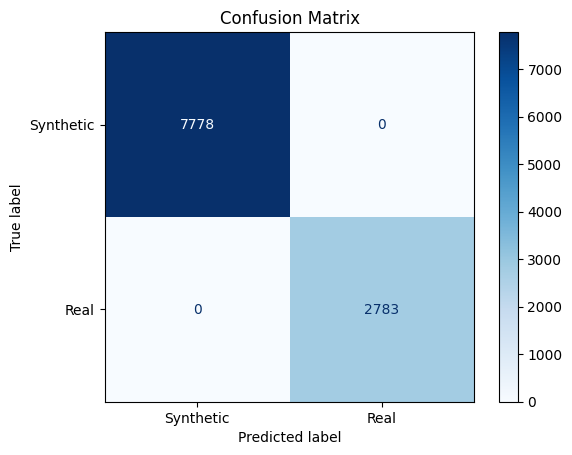

Testing unseen all samples (UID)
              --> Val Acc: 80.83%
              --> Balanced Acc: 0.7426 | Precision: 0.7660
              --> Recall: 1.0000 | F1: 0.8675 | F2: 0.9424
              --> EER: 0.0839 | actDCF: 1.0000 | minDCF: 0.1670
              --> CLLR: 3.9467


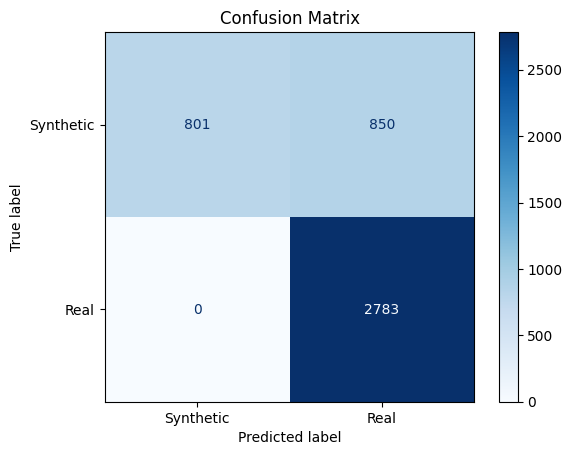

Testing unseen all samples (UID) w/ Google TTS
              --> Val Acc: 65.13%
              --> Balanced Acc: 0.7108 | Precision: 0.5325
              --> Recall: 1.0000 | F1: 0.6950 | F2: 0.8507
              --> EER: 0.0518 | actDCF: 1.0000 | minDCF: 0.0984
              --> CLLR: 2.8747


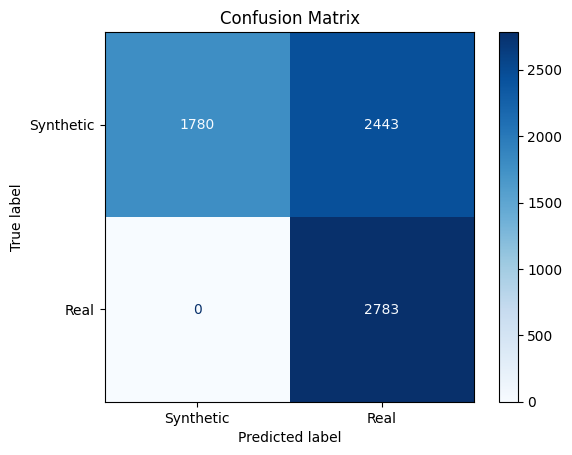

Testing unseen all samples (UnID)
              --> Val Acc: 96.16%
              --> Balanced Acc: 0.5000 | Precision: 0.9616
              --> Recall: 1.0000 | F1: 0.9804 | F2: 0.9921
              --> EER: 0.0642 | actDCF: 1.0000 | minDCF: 0.1053
              --> CLLR: 6.3362


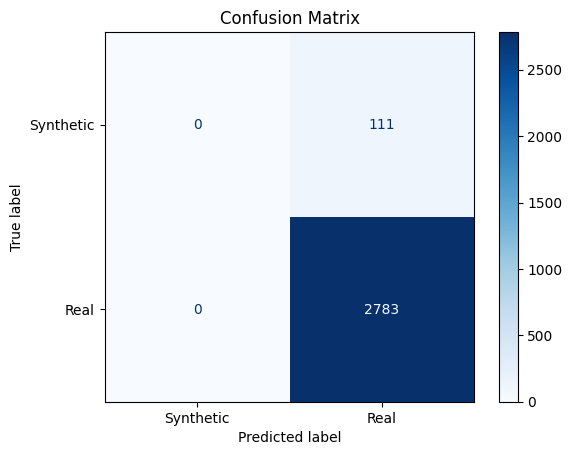

In [9]:
waveform_model_config = {
    'in_channels': 1,
    'first_conv': 3,
    'filts': [128, [128, 128], [128, 256], [256, 256]],
    'blocks': [2, 4],
    'gru_node': 1024,
    'nb_gru_layer': 1,
    'nb_fc_node': 1024,
    'nb_classes': 2,
    'input_length': 16000 * 4
}

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Set up model, optimizer, and scaler ---
model = RawNet(waveform_model_config, device).to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
scaler = GradScaler()

# --- Load the model ---
start_epoch = load_model_rawnet1(
    model, optimizer, scaler,
    path=r"pretrained_weights/waveform/RawNet1/rawnet1_waveform-ep_30-bs_32-lr_0.0001.pth"
)

for key, test_sample in waveform_test_samples_dataloaders.items():
    print(f"Testing {key}")
    if key in main_keys:
        predictions, targets, metrics = test_rawnet1(model, test_sample, device=device)
    # else:
    #     predictions = test_rawnet1_with_loaders(model, test_sample, device=device)
    #     print(predictions)
    torch.cuda.empty_cache()

## RawNet2

Loaded model from pretrained_weights/waveform/RawNet2/rawnet2_waveform-ep_30-bs_32-lr_0.0001.pth (epoch 29)
Testing spoof elevenmultilingualv2 converted samples
Testing spoof elevenmultilingualv2 tts samples
Testing spoof dupdub converted samples
Testing spoof dupdub tts samples
Testing spoof dupdub notindataset tts samples
Testing spoof facebookmms converted samples
Testing spoof facebookmms tts samples
Testing spoof googletts converted samples
Testing spoof googletts tts samples
Testing spoof vits converted samples
Testing spoof vits tts samples
Testing bonafide commonvoice samples
Testing bonafide prosa samples
Testing spoof all samples
Testing bonafide all samples
Testing seen all samples
              --> Val Acc: 99.98%
              --> Balanced Acc: 0.9998 | Precision: 0.9996
              --> Recall: 0.9996 | F1: 0.9996 | F2: 0.9996
              --> EER: 0.0003 | actDCF: 1.0000 | minDCF: 0.0003
              --> CLLR: 0.0007


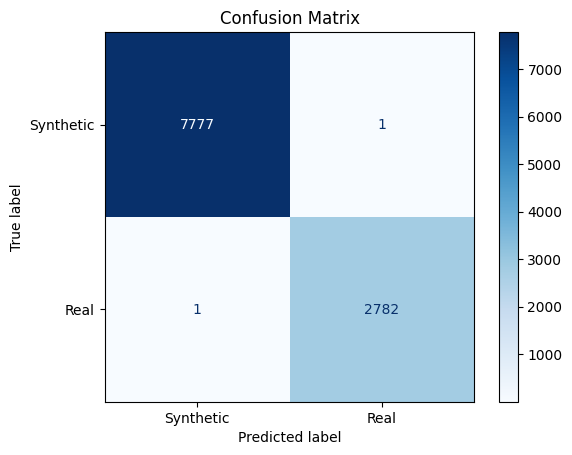

Testing unseen all samples (UID)
              --> Val Acc: 95.69%
              --> Balanced Acc: 0.9423 | Precision: 0.9361
              --> Recall: 0.9996 | F1: 0.9668 | F2: 0.9862
              --> EER: 0.0378 | actDCF: 1.0000 | minDCF: 0.0575
              --> CLLR: 0.7065


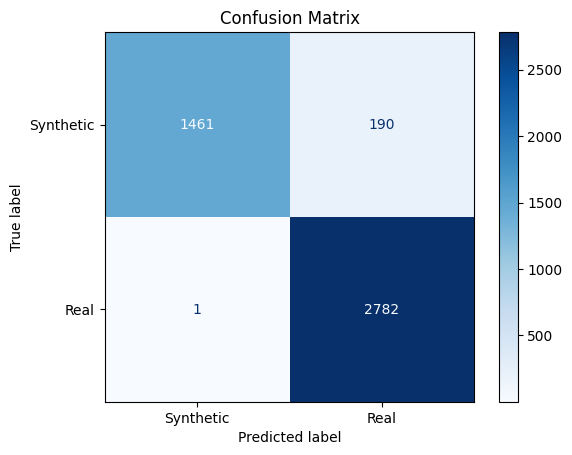

Testing unseen all samples (UID) w/ Google TTS
              --> Val Acc: 91.09%
              --> Balanced Acc: 0.9261 | Precision: 0.8170
              --> Recall: 0.9996 | F1: 0.8992 | F2: 0.9569
              --> EER: 0.0285 | actDCF: 1.0000 | minDCF: 0.0431
              --> CLLR: 0.7152


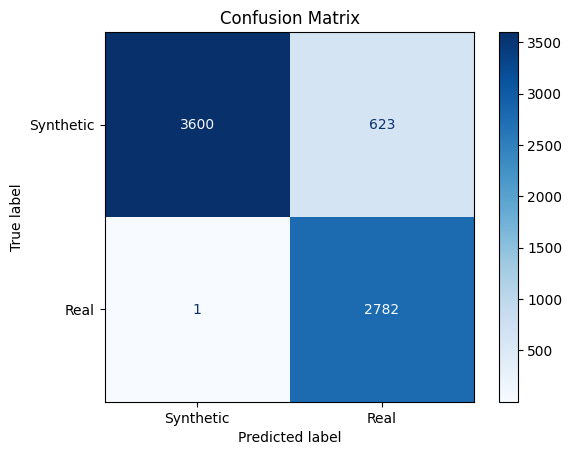

Testing unseen all samples (UnID)
              --> Val Acc: 96.13%
              --> Balanced Acc: 0.4998 | Precision: 0.9616
              --> Recall: 0.9996 | F1: 0.9803 | F2: 0.9918
              --> EER: 0.2213 | actDCF: 1.0000 | minDCF: 0.3867
              --> CLLR: 8.0202


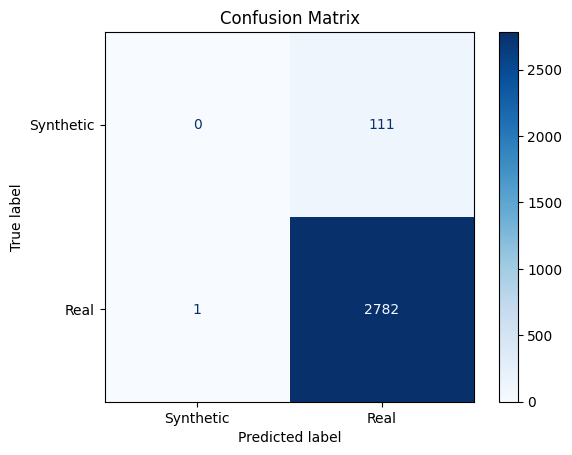

In [10]:
waveform_model_config2 = {
    'in_channels': 1,
    'first_conv': 3,
    'filts': [128, [128, 128], [128, 256], [256, 256]],
    'blocks': [2, 4],
    'gru_node': 1024,
    'nb_gru_layer': 1,
    'nb_fc_node': 1024,
    'nb_classes': 2,
    'nb_samp': 16000 * 4
}

# --- Set up model, optimizer, and scaler ---
model = RawNet2(waveform_model_config2).to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
scaler = GradScaler()

# --- Load the model ---
start_epoch = load_model_rawnet2(
    model, optimizer, scaler,
    path=r"pretrained_weights/waveform/RawNet2/rawnet2_waveform-ep_30-bs_32-lr_0.0001.pth"
)

for key, test_sample in waveform_test_samples_dataloaders.items():
    print(f"Testing {key}")
    if key in main_keys:
        predictions, targets, metrics = test_rawnet2(model, test_sample, device=device)
    # else:
    #     predictions = test_rawnet2_with_loaders(model, test_sample, device=device)
    #     print(predictions)
    torch.cuda.empty_cache()

## RawNet3

Loaded model from pretrained_weights/waveform/RawNet3/rawnet3_waveform-ep_30-bs_32-lr_0.0001.pth (epoch 29)
Testing spoof elevenmultilingualv2 converted samples
Testing spoof elevenmultilingualv2 tts samples
Testing spoof dupdub converted samples
Testing spoof dupdub tts samples
Testing spoof dupdub notindataset tts samples
Testing spoof facebookmms converted samples
Testing spoof facebookmms tts samples
Testing spoof googletts converted samples
Testing spoof googletts tts samples
Testing spoof vits converted samples
Testing spoof vits tts samples
Testing bonafide commonvoice samples
Testing bonafide prosa samples
Testing spoof all samples
Testing bonafide all samples
Testing seen all samples
              --> Val Acc: 100.00%
              --> Balanced Acc: 1.0000 | Precision: 1.0000
              --> Recall: 1.0000 | F1: 1.0000 | F2: 1.0000
              --> EER: 0.0000 | actDCF: 1.0000 | minDCF: 0.0000
              --> CLLR: 0.0010


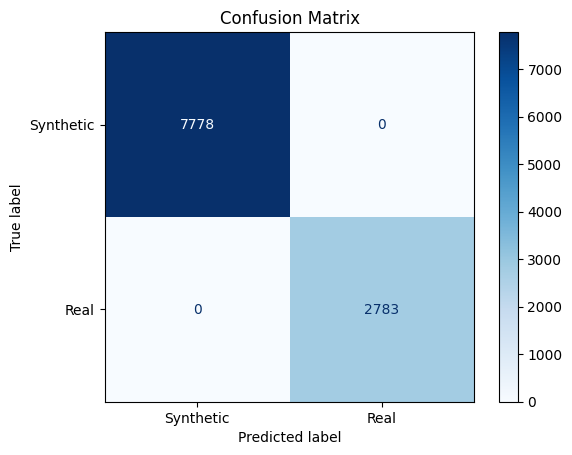

Testing unseen all samples (UID)
Testing unseen all samples (UID) w/ Google TTS
              --> Val Acc: 75.95%
              --> Balanced Acc: 0.8005 | Precision: 0.6229
              --> Recall: 1.0000 | F1: 0.7676 | F2: 0.8920
              --> EER: 0.0248 | actDCF: 1.0000 | minDCF: 0.0492
              --> CLLR: 1.1798


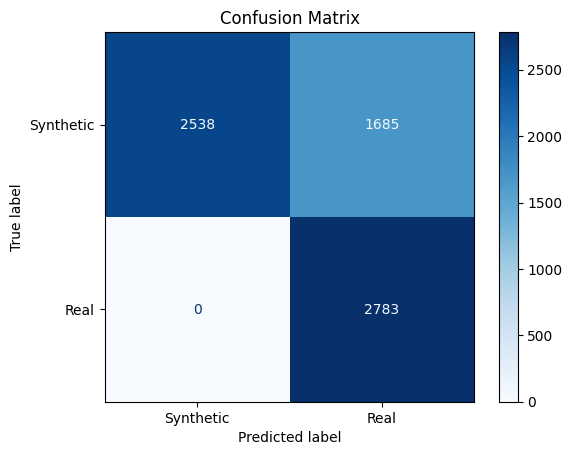

Testing unseen all samples (UnID)
              --> Val Acc: 96.37%
              --> Balanced Acc: 0.5270 | Precision: 0.9636
              --> Recall: 1.0000 | F1: 0.9815 | F2: 0.9925
              --> EER: 0.1612 | actDCF: 1.0000 | minDCF: 0.2745
              --> CLLR: 3.9983


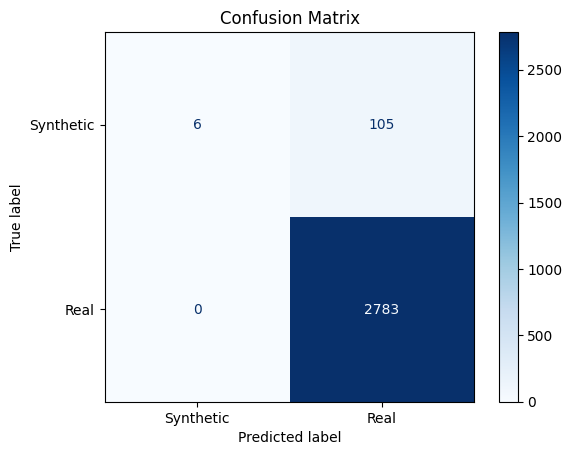

In [3]:
waveform_model_config3 = {
    "nOut": 2,
    "sinc_stride": 10,
    "encoder_type": "ECA",
    "log_sinc": True,
    "norm_sinc": "mean_std",
    "out_bn": True
}

# --- Set up model, optimizer, and scaler ---
model = RawNet3(**waveform_model_config3).to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
scaler = GradScaler()

# --- Load the model ---
start_epoch = load_model_rawnet3(
    model, optimizer, scaler,
    path=r"pretrained_weights/waveform/RawNet3/rawnet3_waveform-ep_30-bs_32-lr_0.0001.pth"
)

for key, test_sample in waveform_test_samples_dataloaders.items():
    print(f"Testing {key}")
    if key in main_keys:
        predictions, targets, metrics = test_rawnet3(model, test_sample, device=device)
    # else:
    #     predictions = test_rawnet3_with_loaders(model, test_sample, device=device)
    #     print(predictions)
    torch.cuda.empty_cache()